In [2]:
import wandb
api = wandb.Api()
#run = api.run("<entity>/<project>/<run_id>")
id_baseline_64 = 'lyff59ic'
id_tanh_64 = '8aiug7vh'
id_baseline_32 = 'vp056zrl'
id_tanh_32 = 'aus0fnzu'
run = api.run("renbotu/fno/fcuvm220")


In [32]:
import numpy as np
# Define the project name and IDs
project_name = "renbotu/fno"
ids = {
    'Baseline+modes64': 'lyff59ic',
    'AMP+HP+tanh+modes64': '8aiug7vh',
    'Baseline+modes32': 'vp056zrl',
    'AMP+HP+tanh+modes32': 'aus0fnzu'
}

# Define the metrics to extract
metrics = ["time", "128_h1"]

# Create dictionaries to store the data
data_time = {}
data_128_h1 = {}

# Loop through the methods and extract the metrics
for method, exp_id in ids.items():
    # Access the W&B run
    run = wandb.Api().run(f"{project_name}/{exp_id}")

    # Get the history for the run
    history = run.history()

    # Extract the metrics data
    time_data = history[metrics[0]]
    h1_data = history[metrics[1]]

    # Store the data in the dictionaries
    data_time[method] = np.array(time_data)
    data_128_h1[method] = np.array(h1_data)



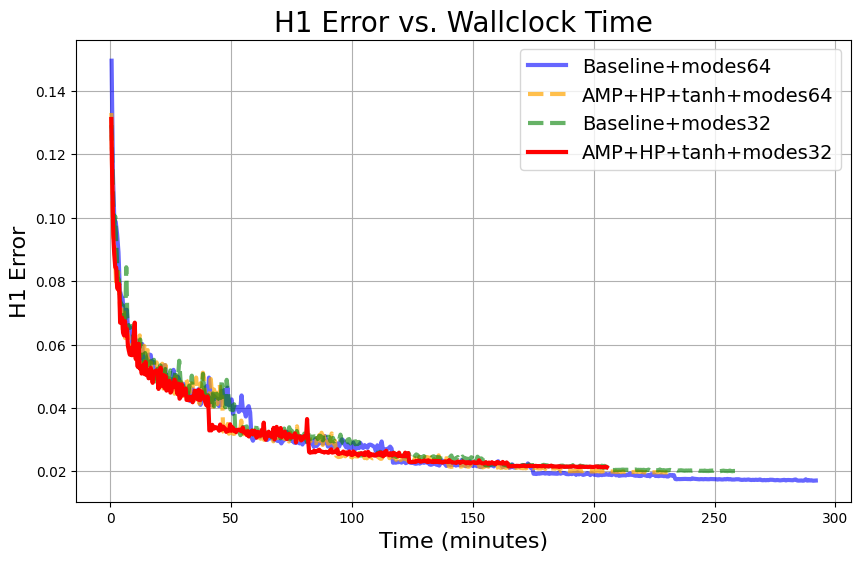

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
def plot_training_curves(data_time, data_losses, methods):
    plt.figure(figsize=(10, 6))

    colors = ['blue', 'orange', 'green', 'red']
    line_styles = ['-', '--', '--', '-']
    markers = ['o', 's', '^', 'x']
    line_widths = [3]*4
    alphas = [0.6, 0.7, 0.6, 1.0]

    for i, method in enumerate(methods):        
        time = data_time[method]
        losses = data_losses[method]
        
        cumulative_time = np.nancumsum(time) / 60  # Calculate cumulative time
        plt.plot(cumulative_time, losses, label=method,  color=colors[i], linestyle=line_styles[i], linewidth=line_widths[i], alpha=alphas[i])
    
    plt.xlabel('Time (minutes)', fontsize=16)
    plt.ylabel('H1 Error', fontsize=16)
    plt.title('H1 Error vs. Wallclock Time', fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.savefig('error_vs_time.pdf', format='pdf')
    plt.show()


methods = ids.keys()

plot_training_curves(data_time, data_128_h1, methods)


/home/renbo/anaconda3/envs/low-precision/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


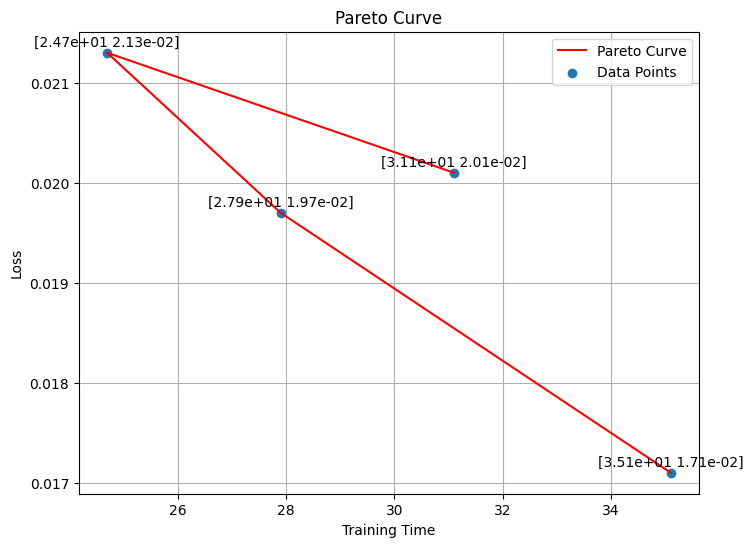

In [40]:


def plot_pareto_curve(training_time, loss):
    plt.figure(figsize=(8, 6))

    # Plot data points
    plt.scatter(training_time, loss, label='Data Points')

    # Combine training_time and loss into a single array
    points = np.column_stack((training_time, loss))

    # Calculate convex hull
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]

    # Sort Pareto curve points based on training time
    pareto_training_time = hull_points[:, 0]
    pareto_loss = hull_points[:, 1]

    # Plot Pareto curve
    plt.plot(pareto_training_time, pareto_loss, color='red', label='Pareto Curve')

    # Add annotations to each point
    for i, txt in enumerate(hull_points):
        plt.annotate(txt, (pareto_training_time[i], pareto_loss[i]), textcoords="offset points", xytext=(0,5), ha='center')

    plt.xlabel('Training Time')
    plt.ylabel('Loss')
    plt.title('Pareto Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
training_time = [31.1, 24.7, 35.1, 27.9]
loss = [0.0201, 0.0213, 0.0171, 0.0197]

plot_pareto_curve(training_time, loss)

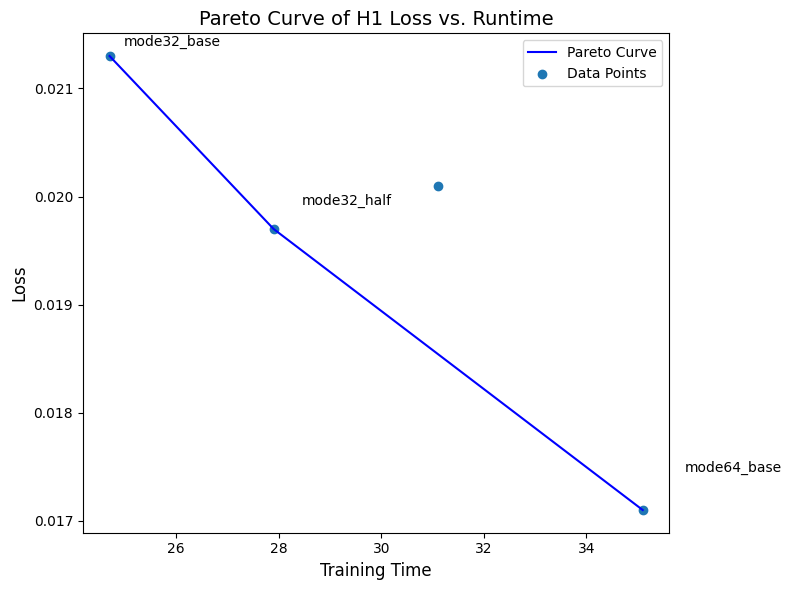

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pareto_curve(training_time, loss):
    plt.figure(figsize=(8, 6))
    plt.scatter(training_time, loss, label='Data Points')

    # Find the leftmost, bottom-most, and additional point
    leftmost_idx = np.argmin(training_time)
    bottommost_idx = np.argmin(loss)
    #additional_idx = np.where((training_time < training_time[leftmost_idx]) & (loss < loss[bottommost_idx]))[0]
    additional_idx = 3

    # Plot the leftmost, bottom-most, and additional points
    #plt.scatter(training_time[leftmost_idx], loss[leftmost_idx], color='red')
    #plt.scatter(training_time[bottommost_idx], loss[bottommost_idx], color='green')
    #plt.scatter(training_time[additional_idx], loss[additional_idx], color='orange')

    # Connect the points in the Pareto curve
    pareto_points = np.array([[training_time[leftmost_idx], loss[leftmost_idx]],
                              [training_time[bottommost_idx], loss[bottommost_idx]],
                              [training_time[additional_idx], loss[additional_idx]]])
    pareto_points = pareto_points[np.argsort(pareto_points[:, 0])]
    plt.plot(pareto_points[:, 0], pareto_points[:, 1], color='blue', label='Pareto Curve')

    # Add method names as annotations
    text_offset = 10
    for i, (x, y) in enumerate(pareto_points):
        method_name = methods[i]
        plt.annotate(f'{method_name}', (x, y), textcoords="offset points",
                     xytext=(text_offset, text_offset), ha='left', va='center')
        text_offset += 10

    plt.xlabel('Training Time', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Pareto Curve of H1 Loss vs. Runtime', fontsize=14)
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Example usage:
training_time = [31.1, 24.7, 35.1, 27.9]
loss = [0.0201, 0.0213, 0.0171, 0.0197]
methods = ['mode32_base', 'mode32_half', 'mode64_base', 'mode64_half']

plot_pareto_curve(training_time, loss)

In [40]:


def plot_pareto_curve(training_time, loss, methods):
    plt.figure(figsize=(8, 6))

    # Plot the data points
    plt.scatter(training_time, loss)
    # Find the leftmost, bottom-most, and additional point
    leftmost_idx = np.argmin(training_time)
    bottommost_idx = np.argmin(loss)
    #additional_idx = np.where((training_time < training_time[leftmost_idx]) & (loss < loss[bottommost_idx]))[0]
    additional_idx = 5
    additional_idx_1 = 6
    additional_idx_2 = 7

    # Plot the leftmost, bottom-most, and additional points
    #plt.scatter(training_time[leftmost_idx], loss[leftmost_idx], color='red')
    #plt.scatter(training_time[bottommost_idx], loss[bottommost_idx], color='green')
    #plt.scatter(training_time[additional_idx], loss[additional_idx], color='orange')

    # Connect the points in the Pareto curve
    pareto_points = np.array([[training_time[leftmost_idx], loss[leftmost_idx]],
                              [training_time[bottommost_idx], loss[bottommost_idx]],
                              [training_time[additional_idx], loss[additional_idx]],
                              [training_time[additional_idx_1], loss[additional_idx_1]],
                              [training_time[additional_idx_2], loss[additional_idx_2]]])
    pareto_points = pareto_points[np.argsort(pareto_points[:, 0])]
    plt.plot(pareto_points[:, 0], pareto_points[:, 1], color='black', label='Pareto Curve')

    # Create a dictionary to map each unique method to a color and a legend handle
    method_legend_handles = {}
    
    # Plot the data points with the same color and legend handle for the same method
    for i, method in enumerate(methods):
        if method not in method_legend_handles:
            color = plt.cm.tab10(len(method_legend_handles))
            legend_handle = plt.scatter([], [], color=color, label=method)
            method_legend_handles[method] = legend_handle
        plt.scatter(training_time[i], loss[i], color=method_legend_handles[method].get_facecolor()[0])
    
    
    plt.xlabel('Training Time', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('Pareto Curve of H1 Loss vs. Runtime', fontsize=20)
    # Create a shared legend for data points with the same method
    legend_handles = [method_legend_handles[method] for method in method_legend_handles]
    plt.legend(handles=legend_handles, fontsize=14, loc='upper right')
    
    plt.grid(False)
    plt.tight_layout()
    plt.savefig('pareto_curve_v100.pdf', format='pdf')
    plt.show()


# Example usage:
training_time = [31.1, 24.7, 35.1, 27.9]
loss = [0.0201, 0.0213, 0.0171, 0.0197]
training_time.extend([30.8, 24.6, 35.3, 27.7])
loss.extend([0.0201, 0.0213, 0.0171, 0.0197])

methods = ['mode32_base', 'mode32_half', 'mode64_base', 'mode64_half']
methods.extend(['mode32_base', 'mode32_half', 'mode64_base', 'mode64_half'])

#plot_pareto_curve(training_time, loss, methods)


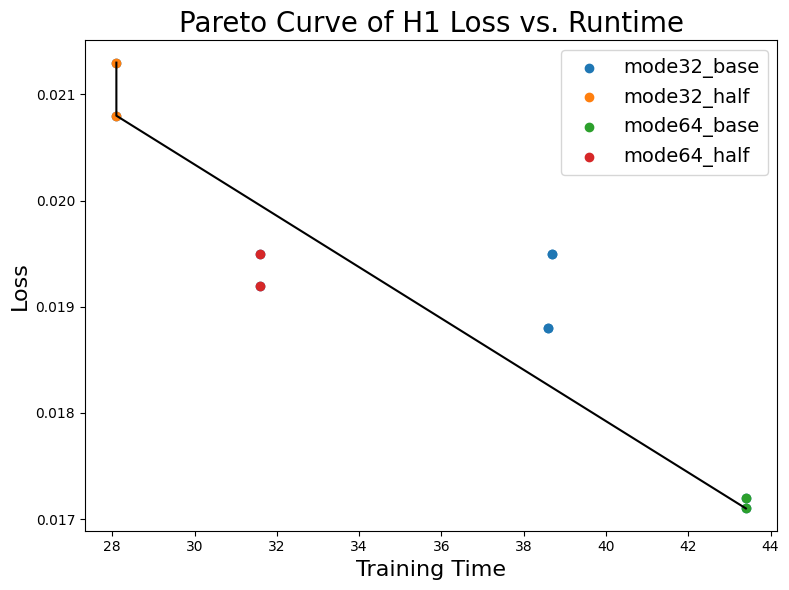

In [41]:

training_time = [38.7, 28.1, 43.4, 31.6, 38.6, 28.1, 43.4, 31.6]
loss = [0.0195, 0.0213, 0.0172, 0.0195, 0.0188, 0.0208, 0.0171, 0.0192 ]
methods = ['mode32_base', 'mode32_half', 'mode64_base', 'mode64_half']
methods.extend(methods)

plot_pareto_curve(training_time, loss, methods)

In [67]:
def plot_runtimes(runtimes, labels):
    plt.figure(figsize=(10, 6))

    x = np.arange(len(runtimes))
    colors = plt.cm.get_cmap('Set3', len(runtimes))

    # Find the index of the slowest method
    slowest_idx = np.argmax(runtimes)
    slowest_time = runtimes[slowest_idx]

    # Calculate speedup percentage for each method
    speedups = [(slowest_time - t) / slowest_time * 100 for t in runtimes]

    # Sort runtimes and labels based on slowest to fastest
    runtimes_sorted, labels_sorted, speedups_sorted = zip(*sorted(zip(runtimes, labels, speedups), reverse=True))

    bars = plt.bar(x, runtimes_sorted, color=colors(x))
    plt.xticks(x, labels_sorted, rotation='horizontal')
    plt.xlabel('Methods', fontsize=16)
    plt.ylabel('Runtime (seconds)', fontsize=16)
    plt.title('Runtimes of Methods per Epoch', fontsize=18)
    plt.grid(False)

    # Add text on top of each bar
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                 f'{speedups_sorted[i]:.1f}%', ha='center', va='bottom', fontdict={'fontsize': 14})

    plt.tight_layout()
    plt.savefig('runtimes_v100.pdf', format='pdf')

    plt.show()

# Example usage:
runtimes = [44.44,
42.25,
39.02,
35.63,
37.35]
labels = ['Baseline',
'AMP',
'Half-Precision FNO (HP)',
'AMP + HP',
'AMP + HP + full-FFT']


#plot_runtimes(runtimes, labels)

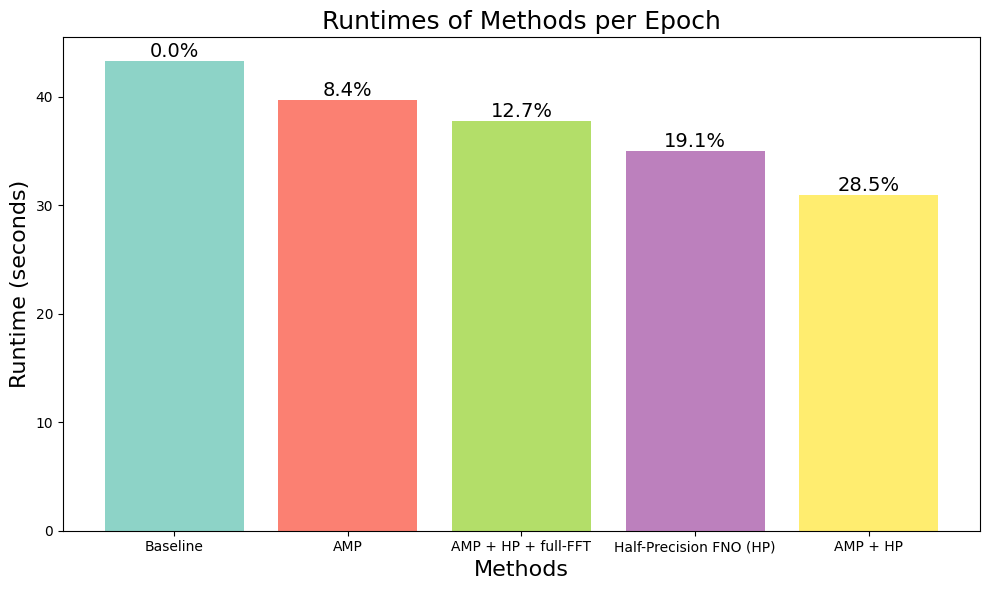

In [68]:
# Example usage:
runtimes = [43.3,
39.65,
35.01,
30.96,
37.8]

labels = ['Baseline',
'AMP',
'Half-Precision FNO (HP)',
'AMP + HP',
'AMP + HP + full-FFT']

plot_runtimes(runtimes, labels)